In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt


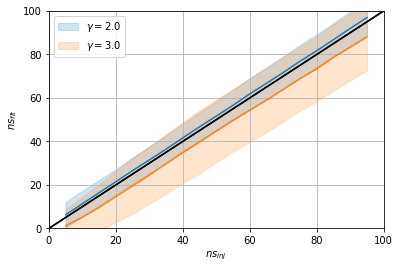

In [33]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'm']

i = 0
for gamma in [2.0, 3.0]:
    ns_fits = []
    ns_upper = []
    ns_lower = []
    nss = np.arange(5.0,100.0,5.0)
    for ns in nss:
        flist = glob.glob('/data/user/wluszczak/KDE_csky/tint/ns/NGC1068/tint_%s_%s_*.npy'%(ns, gamma))
        data = np.load(flist[0])
        tdata = np.transpose(data)
        ts = tdata[0]
        ns_fit = tdata[1]
        gamma_fit = tdata[2]

        std = np.std(ns_fit)
        ns_avg = np.median(ns_fit)

        ns_fits.append(ns_avg)
        ns_upper.append(ns_avg+std)
        ns_lower.append(ns_avg-std)

    plt.plot(nss, ns_fits, color=colors[i])
    plt.fill_between(nss, ns_lower, ns_upper, color=colors[i], alpha=0.2, label='$\gamma=%s$'%(gamma))

    plt.plot([0,100], [0,100], 'k-')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel('$ns_{inj}$')
    plt.ylabel('$ns_{fit}$')
    i+=1
plt.grid()
plt.legend()

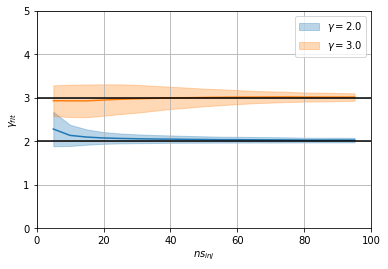

In [34]:
gamma = 2.0
gam_fits = []
gam_upper = []
gam_lower = []
nss = np.arange(5.0,100.0,5.0)
for ns in nss:
    flist = glob.glob('/data/user/wluszczak/KDE_csky/tint/ns/NGC1068/tint_%s_%s_*.npy'%(ns, gamma))
    data = np.load(flist[0])
    tdata = np.transpose(data)
    ts = tdata[0]
    ns_fit = tdata[1]
    gamma_fit = tdata[2]
    
    std = np.std(gamma_fit)
    gam_avg = np.average(gamma_fit)
    
    gam_fits.append(gam_avg)
    gam_upper.append(gam_avg+std)
    gam_lower.append(gam_avg-std)

plt.plot(nss, gam_fits, color='tab:blue')
plt.fill_between(nss, gam_lower, gam_upper, color='tab:blue', alpha=0.3, label='$\gamma=2.0$')

plt.plot([0,100], [gamma,gamma], 'k-')

gamma = 3.0
gam_fits = []
gam_upper = []
gam_lower = []
nss = np.arange(5.0,100.0,5.0)
for ns in nss:
    flist = glob.glob('/data/user/wluszczak/KDE_csky/tint/ns/NGC1068/tint_%s_%s_*.npy'%(ns, gamma))
    data = np.load(flist[0])
    tdata = np.transpose(data)
    ts = tdata[0]
    ns_fit = tdata[1]
    gamma_fit = tdata[2]
    
    std = np.std(gamma_fit)
    gam_avg = np.average(gamma_fit)
    
    gam_fits.append(gam_avg)
    gam_upper.append(gam_avg+std)
    gam_lower.append(gam_avg-std)

plt.plot(nss, gam_fits, color='tab:orange')
plt.fill_between(nss, gam_lower, gam_upper, color='tab:orange', alpha=0.3, label='$\gamma=3.0$')

plt.plot([0,100], [gamma,gamma], 'k-')
plt.xlim(0,100)
plt.ylim(0,5)
plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$\gamma_{fit}$')
plt.legend(loc=0)

[2.0, 4.0, 6.0, 8.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0] [ 4.6467965   6.19049399  6.40028067  8.17139693 11.16767349 13.89780106
 15.05348374 19.34502668 20.73137783 22.09688384 23.73665916 25.38585503]


Text(0.5,1,'dT=20 days, $\\gamma=2.0$')

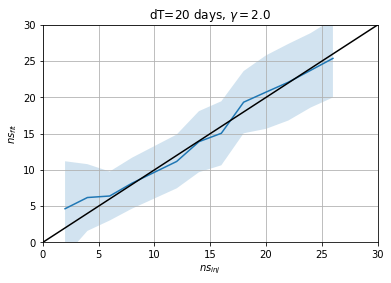

In [38]:
import glob

ns_fit = []
ns_inj = []
ns_err = []
for ns in np.arange(2.0, 30.0, 2.0):
    try:
        f = glob.glob('/data/user/wluszczak/KDE_csky/tdep/sig/sig_recovery/test_flares_%s_2.0_57193.0_10.0_*.npy'%(ns))
        data = np.load(f[0], allow_pickle=True)
        all_ns = []
        for d in data:
            all_ns.append(d['ns'][0])
        med_ns = np.median(all_ns)
        ns_fit.append(med_ns)
        ns_inj.append(ns)
        ns_err.append(np.std(all_ns))
        
    except IndexError:
        pass
    
ns_fit = np.array(ns_fit)
ns_err = np.array(ns_err)
print(ns_inj, ns_fit)
plt.plot(ns_inj, ns_fit)
plt.fill_between(ns_inj, ns_fit-ns_err, ns_fit+ns_err, alpha=0.2)

plt.plot([0,100], [0,100], 'k-')
plt.xlim(0,30)
plt.ylim(0,30)
plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$ns_{fit}$')

plt.title('dT=20 days, $\gamma=2.0$')

[2.0, 4.0, 6.0, 8.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0] [2.49932981 2.06755321 2.11175222 2.02716354 2.0000018  2.00000115
 2.00870061 2.01907158 2.00000262 2.03085509 2.01750895 2.0000137 ]


Text(0.5,1,'dT=20 days, $\\gamma=2.0$')

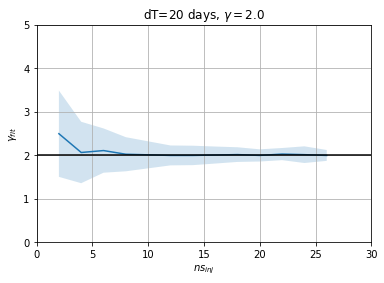

In [39]:
import glob

ns_fit = []
ns_inj = []
ns_err = []
for ns in np.arange(2.0, 30.0, 2.0):
    try:
        f = glob.glob('/data/user/wluszczak/KDE_csky/tdep/sig/sig_recovery/test_flares_%s_2.0_57193.0_10.0_*.npy'%(ns))
        data = np.load(f[0], allow_pickle=True)
        all_ns = []
        for d in data:
            all_ns.append(d['gamma'][0])
        med_ns = np.median(all_ns)
        ns_fit.append(med_ns)
        ns_inj.append(ns)
        ns_err.append(np.std(all_ns))
        
    except IndexError:
        pass
    
ns_fit = np.array(ns_fit)
ns_err = np.array(ns_err)
print(ns_inj, ns_fit)
plt.plot(ns_inj, ns_fit)
plt.fill_between(ns_inj, ns_fit-ns_err, ns_fit+ns_err, alpha=0.2)

plt.plot([0,30],[2,2], 'k-')
plt.xlim(0,30)
plt.ylim(0,5)
plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$\gamma_{fit}$')

plt.title('dT=20 days, $\gamma=2.0$')


[2.0, 4.0, 6.0, 8.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0] [20.32648874 15.39671383 14.67157721 15.77827615 16.53986765 17.20260986
 17.04483546 17.78233554 18.212916   18.0989167  18.43117205 18.73561414] [113.12687956  87.17507983  46.12151068  21.16445166   3.61143438
   4.16651716   3.27333691   3.33373386   1.71011553   2.31795303
   1.62222914   1.43967186]


Text(0.5,1,'dT=20 days, $\\gamma=2.0$')

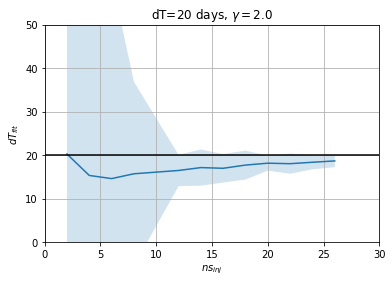

In [40]:
import glob

ns_fit = []
ns_inj = []
ns_err = []
for ns in np.arange(2.0, 30.0, 2.0):
    try:
        f = glob.glob('/data/user/wluszczak/KDE_csky/tdep/sig/sig_recovery/test_flares_%s_2.0_57193.0_10.0_*.npy'%(ns))
        data = np.load(f[0], allow_pickle=True)
        all_ns = []
        for d in data:
            all_ns.append(d['tstop'][0]-d['tstart'][0])
        med_ns = np.median(all_ns)
        ns_fit.append(med_ns)
        ns_inj.append(ns)
        ns_err.append(np.std(all_ns))

        
    except IndexError:
        pass
    
ns_fit = np.array(ns_fit)
ns_err = np.array(ns_err)
print(ns_inj, ns_fit, ns_err)
plt.plot(ns_inj, ns_fit)
plt.fill_between(ns_inj, ns_fit-ns_err, ns_fit+ns_err, alpha=0.2)

plt.plot([0,30], [20,20], 'k-')
plt.xlim(0,30)
plt.ylim(0,50)

plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$dT_{fit}$')

plt.title('dT=20 days, $\gamma=2.0$')

[2.0, 4.0, 6.0, 8.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0] [57185.44365901 57185.43933491 57185.55065505 57185.20510389
 57184.36480307 57184.043135   57184.06823455 57183.85864893
 57183.86570402 57183.73965709 57183.71720678 57183.6241863 ] [1.35864192e+04 9.76853514e+03 5.68993615e+03 1.17215629e+02
 2.74011779e+00 3.30210397e+00 2.87588643e+00 2.63990707e+00
 1.27348490e+00 1.63333456e+00 1.20170932e+00 6.98465413e-01]


Text(0.5,1,'$T_0$ = 57183.0, dT=20 days, $\\gamma=2.0$')

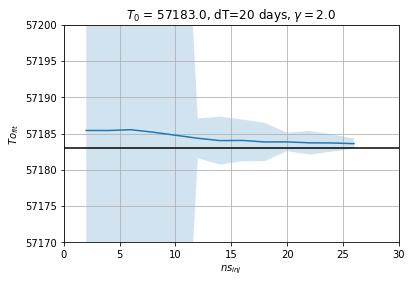

In [41]:
import glob

ns_fit = []
ns_inj = []
ns_err = []
for ns in np.arange(2.0, 30.0, 2.0):
    try:
        f = glob.glob('/data/user/wluszczak/KDE_csky/tdep/sig/sig_recovery/test_flares_%s_2.0_57193.0_10.0_*.npy'%(ns))
        data = np.load(f[0], allow_pickle=True)
        all_ns = []
        for d in data:
            all_ns.append(d['tstart'][0])
        med_ns = np.median(all_ns)
        ns_fit.append(med_ns)
        ns_inj.append(ns)
        ns_err.append(np.std(all_ns))

        
    except IndexError:
        pass
    
ns_fit = np.array(ns_fit)
ns_err = np.array(ns_err)
print(ns_inj, ns_fit, ns_err)
plt.plot(ns_inj, ns_fit)
plt.fill_between(ns_inj, ns_fit-ns_err, ns_fit+ns_err, alpha=0.2)

#plt.plot([0,30], [20,20], 'k-')
plt.axhline(57193.0-10., color='k')
plt.xlim(0,30)
plt.ylim(57170,57200)

plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$To_{fit}$')

plt.title('$T_0$ = 57183.0, dT=20 days, $\gamma=2.0$')